### Training

During **training**, a neural network iteratively performs a forward pass, calculates the loss, makes a backward pass, and updates its parameters. In this case, since the entire trainig dataset is processed in each training iteration, we can refer to each iteration as an epoch.

As shown in the graph below, the loss consistently decreased in each epoch following a hyperbolic shape.

In [ ]:
plt.figure(figsize=(4, 2))
plt.plot(loss_graph)
plt.xlabel('Epoch')
plt.ylabel('Loss');

# MLP



```{admonition} Help
:class: dropdown
The `requires_grad=True` argument indicates that the tensor should track gradients for operations. This will enable to run `loss.backward()` in the backward pass.
```

### Backwards pass

The network calculates gradients by propagating the error backward through the layers, determining how much each parameter contributed to the error. During **backpropagation**, the neural network computes the **gradient of the loss function** with respect to all its parameters by applying the chain rule of calculus.

To compute all the gradients, we will use the PyTorch function `loss.backward()` which kept track of all the operations during the forwards pass. In  [](ch3.ipynb) we will perform a backward pass manually to better understand how backpropagation works and how the gradients are calculated.

### Update Parameters

The calculated gradients are used to adjust the weights and biases through an optimization algorithm to minimize the loss function. Once the gradients have been computed, the neural network progresively **updates its parameters** trying minimize the loss function. The most common optimization techniques for updating the parameters are **gradient descent**, **stochastic gradient descent (SGD)**, and **Adam**.

A **gradient** is a vector that represents the rate of change of a function with respect to its input variables. By default, gradients point in the **direction of steepest ascent**, that is, the direction in which the function increases the fastest. Since we want to minimize the loss function, we will move in the opposite direction of the gradients. 




**Gradient descent** is an optimization algorithm used to minimize a function, frequently used in neural networks training to minimize the loss function.

Gradient descent updates each parameter by subtracting a fraction of the gradient from its current value, scaled by a factor known as the **learning rate**. The learning rate determines the size of the steps we take towards the minimum. A smaller learning rate results in more precise but slower convergence, while a larger learning rate can speed up convergence but may risk overshooting the minimum. The parameter update rule for gradient descent can be expressed mathematically as:

$$
\theta = \theta - \eta \nabla L(\theta)
$$

Where:
- $\theta$ represents the parameters of the neural network
- $\eta$ is the learning rate
- $\nabla L(\theta)$ is the gradient of the loss function with respect to the parameters.

In [ ]:
# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

# transform input tensor from (60000, 28, 28) to (60000, 784)
X = train_x.view(-1, 784)

# forward pass
h1_pre = X @ W1 + b1
h1 = torch.tanh(h1_pre)
h2_pre = h1 @ W2 + b2
h2 = torch.tanh(h2_pre)
logits = h2 @ W3 + b3

# softmax
probs = logits.exp() / logits.exp().sum(1, keepdims=True)

# probability assigned to the correct class for the ith example
pi = probs[(torch.arange(probs.shape[0]), train_y)]

# average negative log liklihood
loss = -pi.log().mean()

print(f"Loss: {loss:.4f}")

Loss: 15.9699


## Backward Pass

A lower loss indicates that the model is making better predictions, assigning higher probabilities to the correct classes. Thus, if we minimize the loss, our model is going to improve its predictions. To know how to adjust the parameters of the model so that we minimize the loss function, we are going to calculate the gradient of the loss function with respect to all its parameters by applying the chain rule of calculus.






````{admonition} Gradient

A gradient is a vector that represents the direction and rate of the fastest increase in a function's value.

The gradient of a 1 dimensional function is just the derivative

To comput the gradient of a 2 dimensional function we have to use partial derivatives




## Batches

&ensp; &ensp; &ensp; &ensp; The neural network was progressively reducing the loss, and therefore learning. However, each epoch took a considerable amount of time because processing the entire dataset of 60,000 images is computationally expensive. To address this issue, we will use a batch, a small randomly selected subset of the training dataset, instead of the entire training dataset in each iteration.

```{important}
When working with bacthes, we will refer to each training iteration as a **step**, not an epoch, because only a subset of the training dataset is processed in each iteration.  

```

```{admonition} Help
:class: dropdown
`torch.randint(0, train_x.shape[0], (batch_size,))` randomly generates *batch_size* (32) integers between 0 and *train_x.shape[0]* (60000) that we will use to index into the dataset.
```

In [10]:
steps = 100        # train iterations
lr = 0.1           # learning rate
batch_size = 32

loss_graph = []
g = torch.Generator().manual_seed(1)

# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

for step in range(steps):
    
    # batch construction
    ix = torch.randint(0, train_x.shape[0], (batch_size,), generator=g)
    Xb = train_x[ix].view(-1, 784)
    Yb = train_y[ix]
    
    # forward pass
    h1 = torch.tanh(Xb @ W1 + b1)  # (batch_size, n_hidden) = (batch_size, 784) x (784, n_hidden) + (n_hidden)
    h2 = torch.tanh(h1 @ W2 + b2)  # (batch_size, n_hidden) = (batch_size, n_hidden) x (n_hidden, n_hidden) + (n_hidden)
    o = h2 @ W3 + b3               # (batch_size, 10) = (batch_size, n_hidden) x (n_hidden, 10) + (10)
    
    # calculate loss
    loss = F.cross_entropy(o, Yb)
    loss_graph.append(loss.item())
    if step % 10 == 0 or step == steps - 1:
        print(f"Step: {step:2d}/{steps}     Loss: {loss.item():.4f}")
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad

Step:  0/100     Loss: 19.2715
Step: 10/100     Loss: 9.7469
Step: 20/100     Loss: 9.2240
Step: 30/100     Loss: 7.1574
Step: 40/100     Loss: 5.5388
Step: 50/100     Loss: 3.6040
Step: 60/100     Loss: 3.6486
Step: 70/100     Loss: 5.2210
Step: 80/100     Loss: 3.3407
Step: 90/100     Loss: 2.6224
Step: 99/100     Loss: 3.0554


&ensp; &ensp; &ensp; &ensp; Because we are using a subset of the dataset, we are computing an approximate gradient instead of the exact gradient. As a result, the loss may temporarily increase during some steps, as shown in the graph below. However, the use of approximate gradients enables faster iterations, which is often better than slower iterations with exact gradients.

In [ ]:
plt.figure(figsize=(4, 2))
plt.plot(loss_graph)
plt.xlabel('Step')
plt.ylabel('Loss');

The loss we are seeing is the loss of each batch. To compute the training loss we have to use the whole training dataset.

In [82]:
def train_loss():

    X = train_x.view(-1, 784)

    # forward pass
    h1 = torch.tanh(X @ W1 + b1)
    h2 = torch.tanh(h1 @ W2 + b2)
    o = h2 @ W3 + b3

    # calculate loss
    loss = F.cross_entropy(o, train_y)
    
    return loss.item()

print(f"Train Loss: {train_loss():.4f}")

Train Loss: 3.1834


In [ ]:
logits = h2 @ W3 + b3
probs = logits.exp() / logits.exp().sum(1, keepdims=True)  # softmax



Train Loss: 3.1834


## Intialization

On step 0 we got a loss of 15.9699. The model should assign about equal probability (1/10) to all the 10 numbers. Hence, we should expect an **initialization loss** close to:

In [165]:
print(f"Expected Initialization Loss: {-torch.tensor(1/10).log():.4f}")

Expected Initialization Loss: 2.3026


Run a single forward pass:

In [ ]:
# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

# batch construction
ix = torch.randint(0, train_x.shape[0], (batch_size,), generator=g)
Xb = train_x[ix].view(-1, 784)
Yb = train_y[ix]

# forward pass
h1 = torch.tanh(Xb @ W1 + b1)
h2 = torch.tanh(h1 @ W2 + b2)
logits = h2 @ W3 + b3
probs = logits.exp() / logits.exp().sum(1, keepdims=True)  # softmax

# calculate loss
pi = probs[(torch.arange(logits.shape[0]), train_y)]
loss = -pi.log().mean()
print(f"Initial Loss: {loss:.4f}")

ValueError: not enough values to unpack (expected 6, got 2)

The issue is that at initialization the **logits coming out of the neural net are not uniform** (they are extreme randomly positive or negative numbers). Some characters are very confident and some characters are very not confident so the network is very confidently wrong recording a high loss.

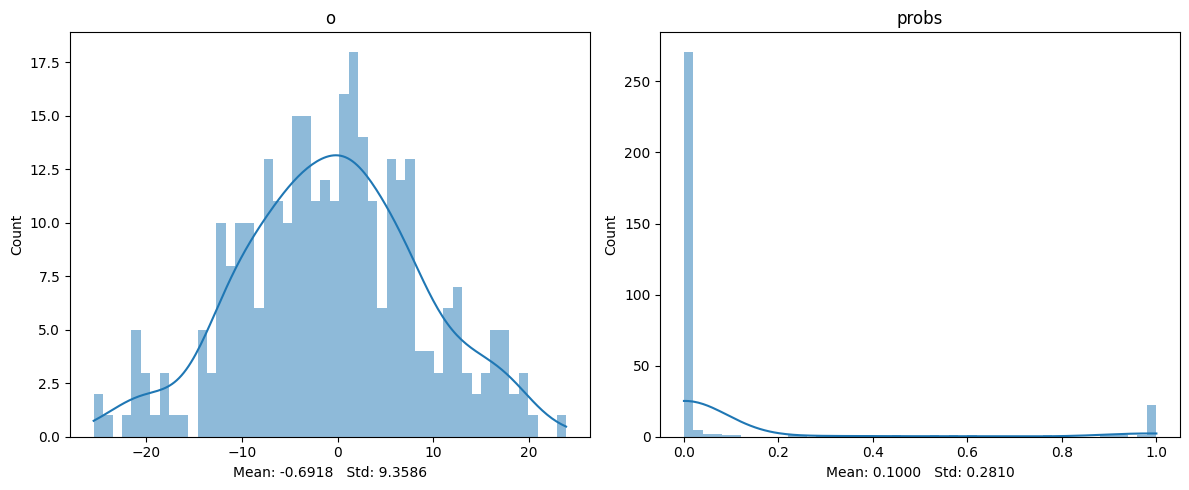

In [17]:
plt.figure(figsize=(12,5))

plt.subplot(121)
sns.histplot(o.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('o')
plt.xlabel(f'Mean: {o.mean():.4f}   Std: {o.std():.4f}')

plt.subplot(122)
sns.histplot(probs.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('probs')
plt.xlabel(f'Mean: {probs.mean():.4f}   Std: {probs.std():.4f}')

plt.tight_layout()

Fix
We have to make the logits closer to 0 so they are more uniform.

Remember that logits = h @ W2 + b2.

Because we want logits to be closer to 0 at initialization we can multiply b2 by 0.

Because we want logits to be closer to 0 at initialization we can multiply W2 by 0.01.

Note: We multiply W2 by 0.01 instead of 0 so there is some antropy.


In [53]:
def initialize_nn(n_hidden = 100):

    g = torch.Generator().manual_seed(1)
    
    W1 = torch.randn((784, n_hidden),      generator=g)
    b1 = torch.zeros(n_hidden)
    W2 = torch.randn((n_hidden, n_hidden), generator=g)
    b2 = torch.zeros(n_hidden)
    W3 = torch.randn((n_hidden, 10),       generator=g) * 0.1
    b3 = torch.zeros(10)
    
    parameters = [W1, b1, W2, b2, W3, b3]
    
    for p in parameters:
        p.requires_grad = True
    
    return parameters

In [54]:
g = torch.Generator().manual_seed(1)

# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

# batch construction
ix = torch.randint(0, train_x.shape[0], (batch_size,), generator=g)
Xb = train_x[ix].view(-1, 784)
Yb = train_y[ix]

# forward pass
h1 = torch.tanh(Xb @ W1 + b1)
h2 = torch.tanh(h1 @ W2 + b2)
o = h2 @ W3 + b3
probs = o.exp() / o.exp().sum(1, keepdims=True)

# calculate loss
loss = -probs[torch.arange(o.shape[0]), Yb].log().mean()
print(f"Initial Loss: {loss:.4f}")

Initial Loss: 3.0767


The logits coming out of the nueral net are more uniform so the network is less confidently wrong recording a lower initialization loss closer to what we expected (3.2958).
Train loss and dev loss are lower because we are spending the first several thousand iterations optimizing the neural net instead of just squashing down the weights.

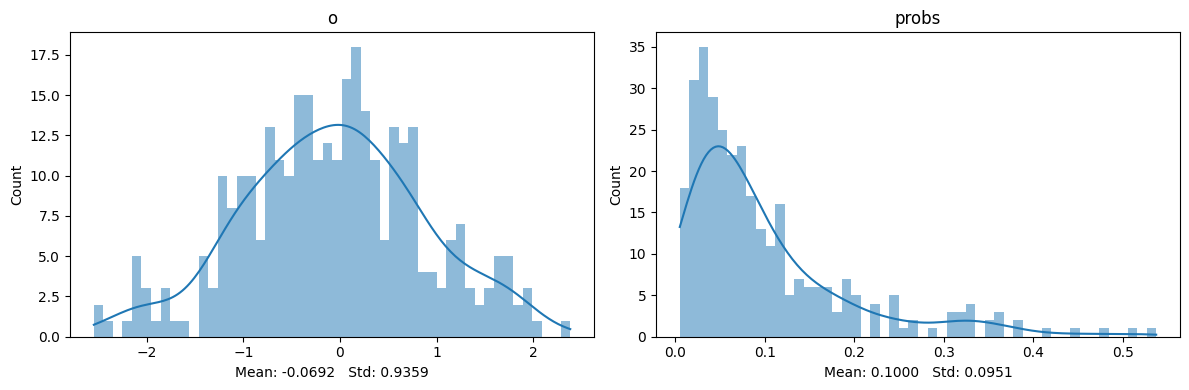

In [55]:
plt.figure(figsize=(12,4))

plt.subplot(121)
sns.histplot(o.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('o')
plt.xlabel(f'Mean: {o.mean():.4f}   Std: {o.std():.4f}')

plt.subplot(122)
sns.histplot(probs.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('probs')
plt.xlabel(f'Mean: {probs.mean():.4f}   Std: {probs.std():.4f}')

plt.tight_layout()

## Kaiming Initialization

Many of the 1st layer activations are either -1 or 1. This occurs because the pre-activations range between -20 and 20, leading the tanh function to saturate. As shown in the graph below, tanh squashes input values into the range [-1, 1], with large positive or negative inputs pushed closer to 1 or -1, respectively.

```{figure} ../images/tanh.png
---
width: 300px
name: tanh
---
tanh (Hyperbolic Tangent). Source: {cite}`weisstein_tanh`
```

In [21]:
steps = 100        # train iterations
lr = 0.1           # learning rate
batch_size = 32

g = torch.Generator().manual_seed(1)

# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

for step in range(steps):
    
    # batch construction
    ix = torch.randint(0, train_x.shape[0], (batch_size,), generator=g)
    Xb = train_x[ix].view(-1, 784)
    Yb = train_y[ix]
    
    # forward pass
    h1_pre = Xb @ W1 + b1
    h1 = torch.tanh(h1_pre)
    h2_pre = h1 @ W2 + b2
    h2 = torch.tanh(h2_pre)
    o = h2 @ W3 + b3
    
    # calculate loss
    loss = F.cross_entropy(o, Yb)
    if step % 10 == 0 or step == steps - 1:
        print(f"Step: {step:2d}/{steps}     Loss: {loss.item():.4f}")
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
    
print(f"\nTrain Loss: {train_loss():.4f}")

Step:  0/100     Loss: 3.0767
Step: 10/100     Loss: 2.0398
Step: 20/100     Loss: 1.7603
Step: 30/100     Loss: 1.6258
Step: 40/100     Loss: 1.4919
Step: 50/100     Loss: 1.2398
Step: 60/100     Loss: 1.1056
Step: 70/100     Loss: 1.1658
Step: 80/100     Loss: 1.0998
Step: 90/100     Loss: 1.0376
Step: 99/100     Loss: 0.9125

Train Loss: 1.0446


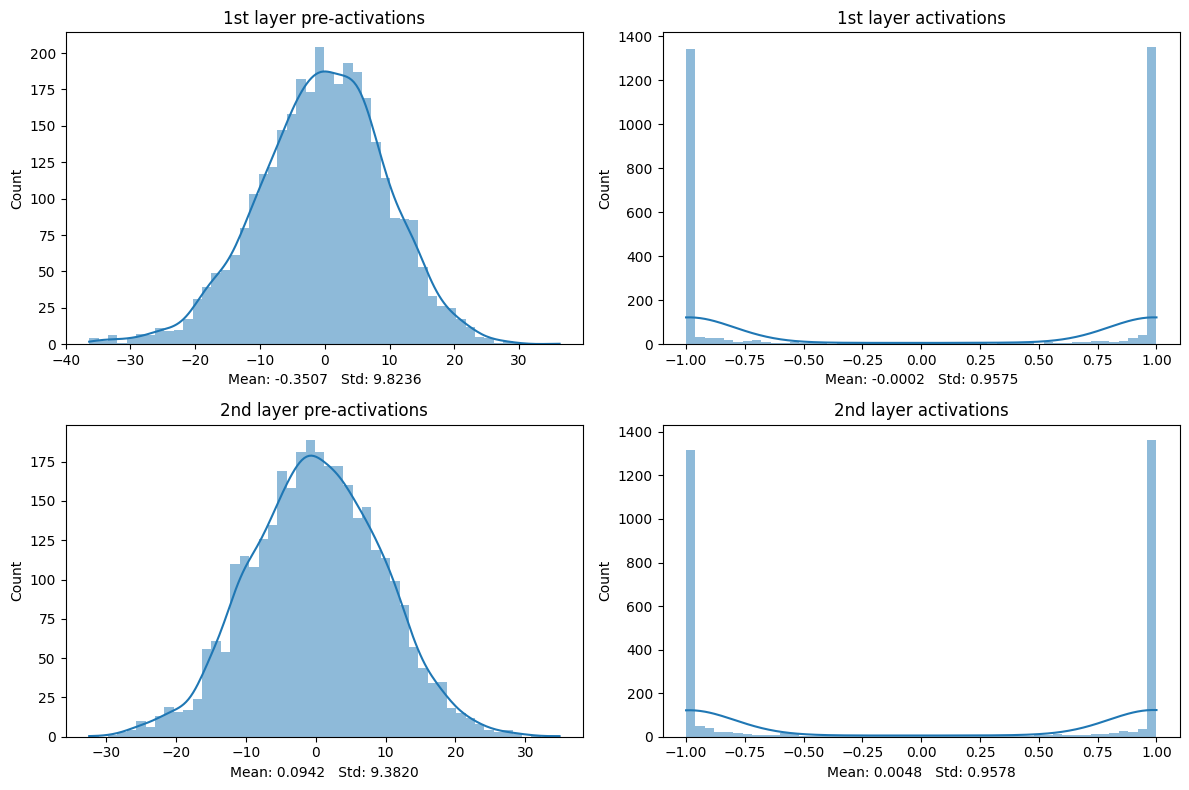

In [22]:
plt.figure(figsize=(12,8))

plt.subplot(221)
sns.histplot(h1_pre.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('1st layer pre-activations')
plt.xlabel(f'Mean: {h1_pre.mean():.4f}   Std: {h1_pre.std():.4f}')

plt.subplot(222)
sns.histplot(h1.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('1st layer activations')
plt.xlabel(f'Mean: {h1.mean():.4f}   Std: {h1.std():.4f}')

plt.subplot(223)
sns.histplot(h2_pre.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('2nd layer pre-activations')
plt.xlabel(f'Mean: {h2_pre.mean():.4f}   Std: {h2_pre.std():.4f}')

plt.subplot(224)
sns.histplot(h2.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('2nd layer activations')
plt.xlabel(f'Mean: {h2.mean():.4f}   Std: {h2.std():.4f}')

plt.tight_layout()

If the activations after applying the tanh function are highly saturated (close to 1 or -1), the new gradients become close to zero during backpropagation, which slows down or even halts learning in the neural network:

$$
\text{new gradient} = (1 - \tanh^2(x)) \cdot \text{gradient}
$$

In the figure below, white pixels represent neurons that are highly saturated, effectively destroying the gradient for that example. If an entire row was white, we would have a **dead neuron**. A dead neuron is a neuron that never activates in the non-flat region of tanh and kills all gradients flowing through it, preventing learning.

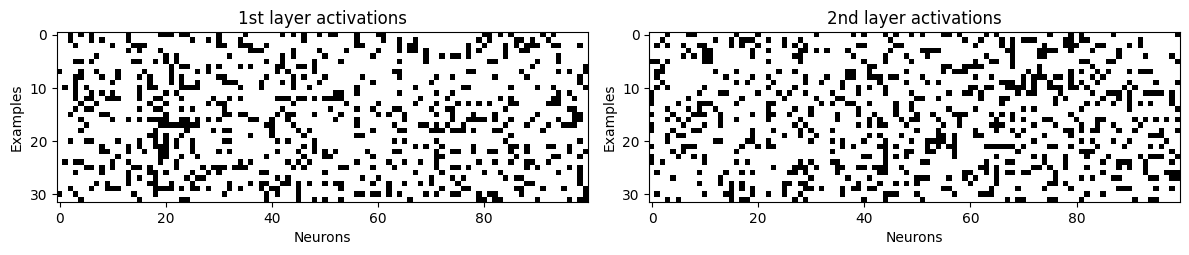

In [23]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(h1.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.title('1st layer activations')
plt.xlabel("Neurons")
plt.ylabel("Examples")

plt.subplot(122)
plt.imshow(h2.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.title('2nd layer activations')
plt.xlabel("Neurons")
plt.ylabel("Examples")

plt.tight_layout()

**Kaiming initialization** (also known as He initialization) is a method used to initialize the weights of a neural network in such a way that the gradients flow more effectively through the network. It was introduced in the paper [He et al. (2015). *Delving Deep into Rectifiers*](https://arxiv.org/pdf/1502.01852) and is particularly important when using nonlinear activation functions such as tanh or ReLU. 


The key idea behind Kaiming initialization is to prevent the activations from becoming too large or too small, which can lead to vanishing or exploding gradients as we just show. It adjusts the weights based on a scaling factor that depends on the activation function (gain) and the number of input units to a neuron (fan-in).

\text{std} = \frac{\text{gain}}{\sqrt{\text{fan-in}}}

In [24]:
def initialize_nn(n_hidden = 100):

    g = torch.Generator().manual_seed(1)
    
    W1 = torch.randn((784, n_hidden),      generator=g) * (5/3) / 784**0.5
    b1 = torch.zeros(n_hidden)
    W2 = torch.randn((n_hidden, n_hidden), generator=g) * (5/3) / n_hidden**0.5
    b2 = torch.zeros(n_hidden)
    W3 = torch.randn((n_hidden, 10),       generator=g) * 0.1
    b3 = torch.zeros(10)
    
    parameters = [W1, b1, W2, b2, W3, b3]
    
    for p in parameters:
        p.requires_grad = True
    
    return parameters

In [25]:
steps = 100        # train iterations
lr = 0.1           # learning rate
batch_size = 32

g = torch.Generator().manual_seed(1)

# intialize neural network
parameters = initialize_nn()
W1, b1, W2, b2, W3, b3 = parameters

for step in range(steps):
    
    # batch construction
    ix = torch.randint(0, train_x.shape[0], (batch_size,), generator=g)
    Xb = train_x[ix].view(-1, 784)
    Yb = train_y[ix]
    
    # forward pass
    h1_pre = Xb @ W1 + b1
    h1 = torch.tanh(h1_pre)
    h2_pre = h1 @ W2 + b2
    h2 = torch.tanh(h2_pre)
    o = h2 @ W3 + b3
    
    # calculate loss
    loss = F.cross_entropy(o, Yb)
    if step % 10 == 0 or step == steps - 1:
        print(f"Step: {step:2d}/{steps}     Loss: {loss.item():.4f}")
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
    
print(f"\nTrain Loss: {train_loss():.4f}")

Step:  0/100     Loss: 2.6472
Step: 10/100     Loss: 1.5634
Step: 20/100     Loss: 1.0335
Step: 30/100     Loss: 0.9549
Step: 40/100     Loss: 0.6777
Step: 50/100     Loss: 0.5479
Step: 60/100     Loss: 0.5596
Step: 70/100     Loss: 0.4691
Step: 80/100     Loss: 0.3141
Step: 90/100     Loss: 0.7109
Step: 99/100     Loss: 0.4797

Train Loss: 0.4643


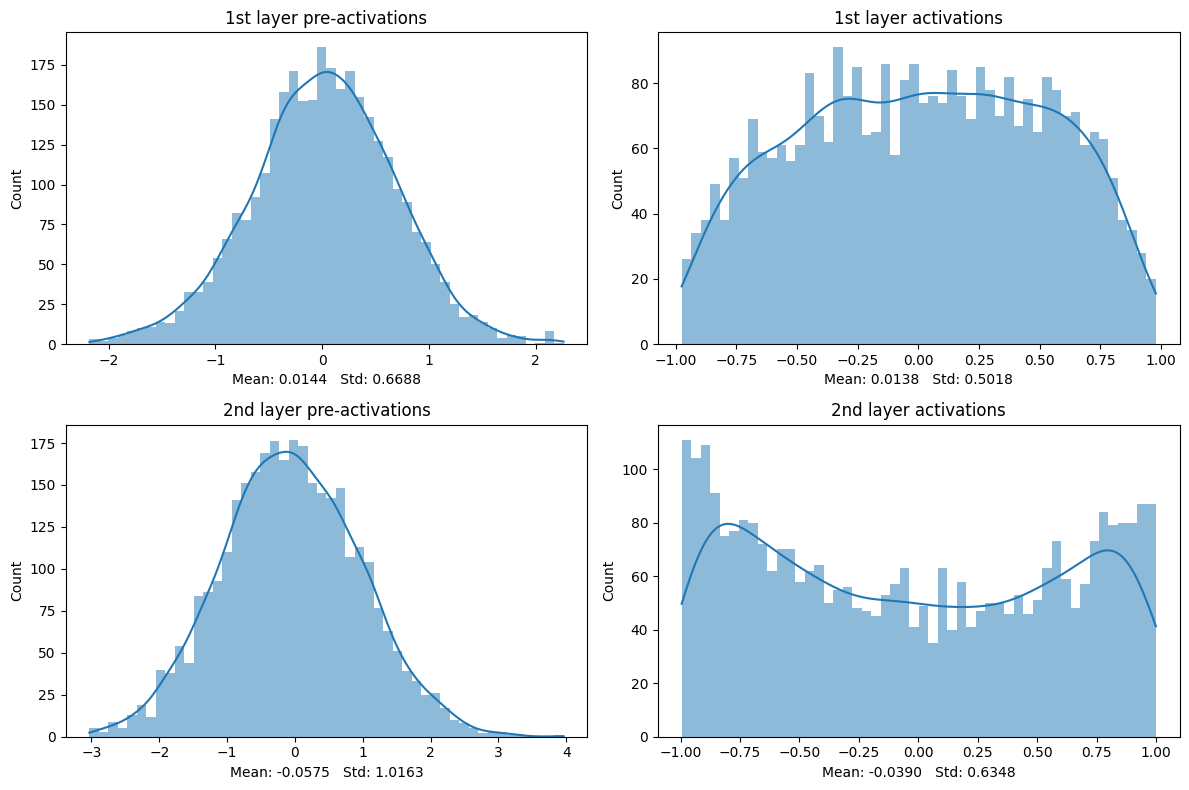

In [26]:
plt.figure(figsize=(12,8))

plt.subplot(221)
sns.histplot(h1_pre.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('1st layer pre-activations')
plt.xlabel(f'Mean: {h1_pre.mean():.4f}   Std: {h1_pre.std():.4f}')

plt.subplot(222)
sns.histplot(h1.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('1st layer activations')
plt.xlabel(f'Mean: {h1.mean():.4f}   Std: {h1.std():.4f}')

plt.subplot(223)
sns.histplot(h2_pre.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('2nd layer pre-activations')
plt.xlabel(f'Mean: {h2_pre.mean():.4f}   Std: {h2_pre.std():.4f}')

plt.subplot(224)
sns.histplot(h2.view(-1).tolist(), bins=50, kde=True, edgecolor='none');
plt.title('2nd layer activations')
plt.xlabel(f'Mean: {h2.mean():.4f}   Std: {h2.std():.4f}')

plt.tight_layout()

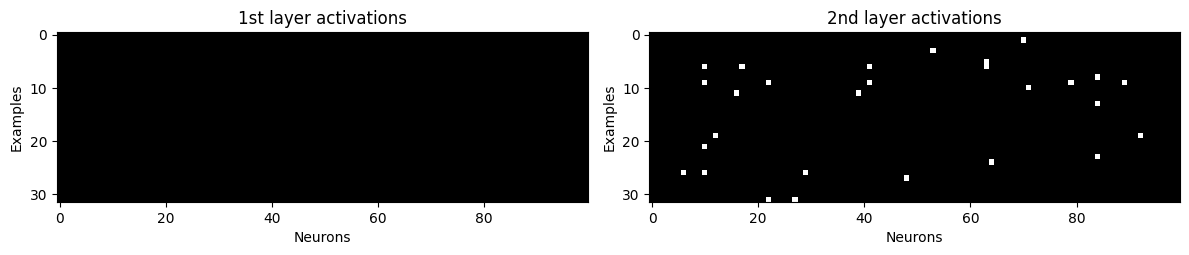

In [27]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(h1.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.title('1st layer activations')
plt.xlabel("Neurons")
plt.ylabel("Examples")

plt.subplot(122)
plt.imshow(h2.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.title('2nd layer activations')
plt.xlabel("Neurons")
plt.ylabel("Examples")

plt.tight_layout()

## Layers as classes

In [15]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=torch.Generator().manual_seed(1)) / fan_in**0.5  # kaiming initialization
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])



class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [532]:
def initialize_nn(n_hidden = 100):
    
    layers = [
        Linear(     784, n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), Tanh(),
        Linear(n_hidden,       10),
    ]
    
    with torch.no_grad():
        # make less confident last layer
        layers[-1].weight *= 0.1

        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= 5/3         # apply kaiming gain
    
    parameters = [p for layer in layers for p in layer.parameters()]
    
    for p in parameters:
        p.requires_grad = True
    
    return layers, parameters

In [533]:
steps = 100        # train iterations
lr = 0.1           # learning rate
batch_size = 32

g = torch.Generator().manual_seed(1)

# intialize neural network
layers, parameters = initialize_nn()

for step in range(steps):
    
    # batch construction
    ix = torch.randint(0, train_x.shape[0], (batch_size,), generator=g)
    Xb = train_x[ix].view(-1, 784)
    Yb = train_y[ix]

    # forward pass
    x = Xb
    for layer in layers:
        x = layer(x)
    
    # calculate loss
    for layer in layers:
        layer.out.retain_grad()       # DEBUG: retain_grad serves for the graphs
    loss = F.cross_entropy(x, Yb)
    if step % 10 == 0 or step == steps - 1:
        print(f"Step: {step:2d}/{steps}     Loss: {loss.item():.4f}")
        
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
    
    break

Step:  0/100     Loss: 2.3075


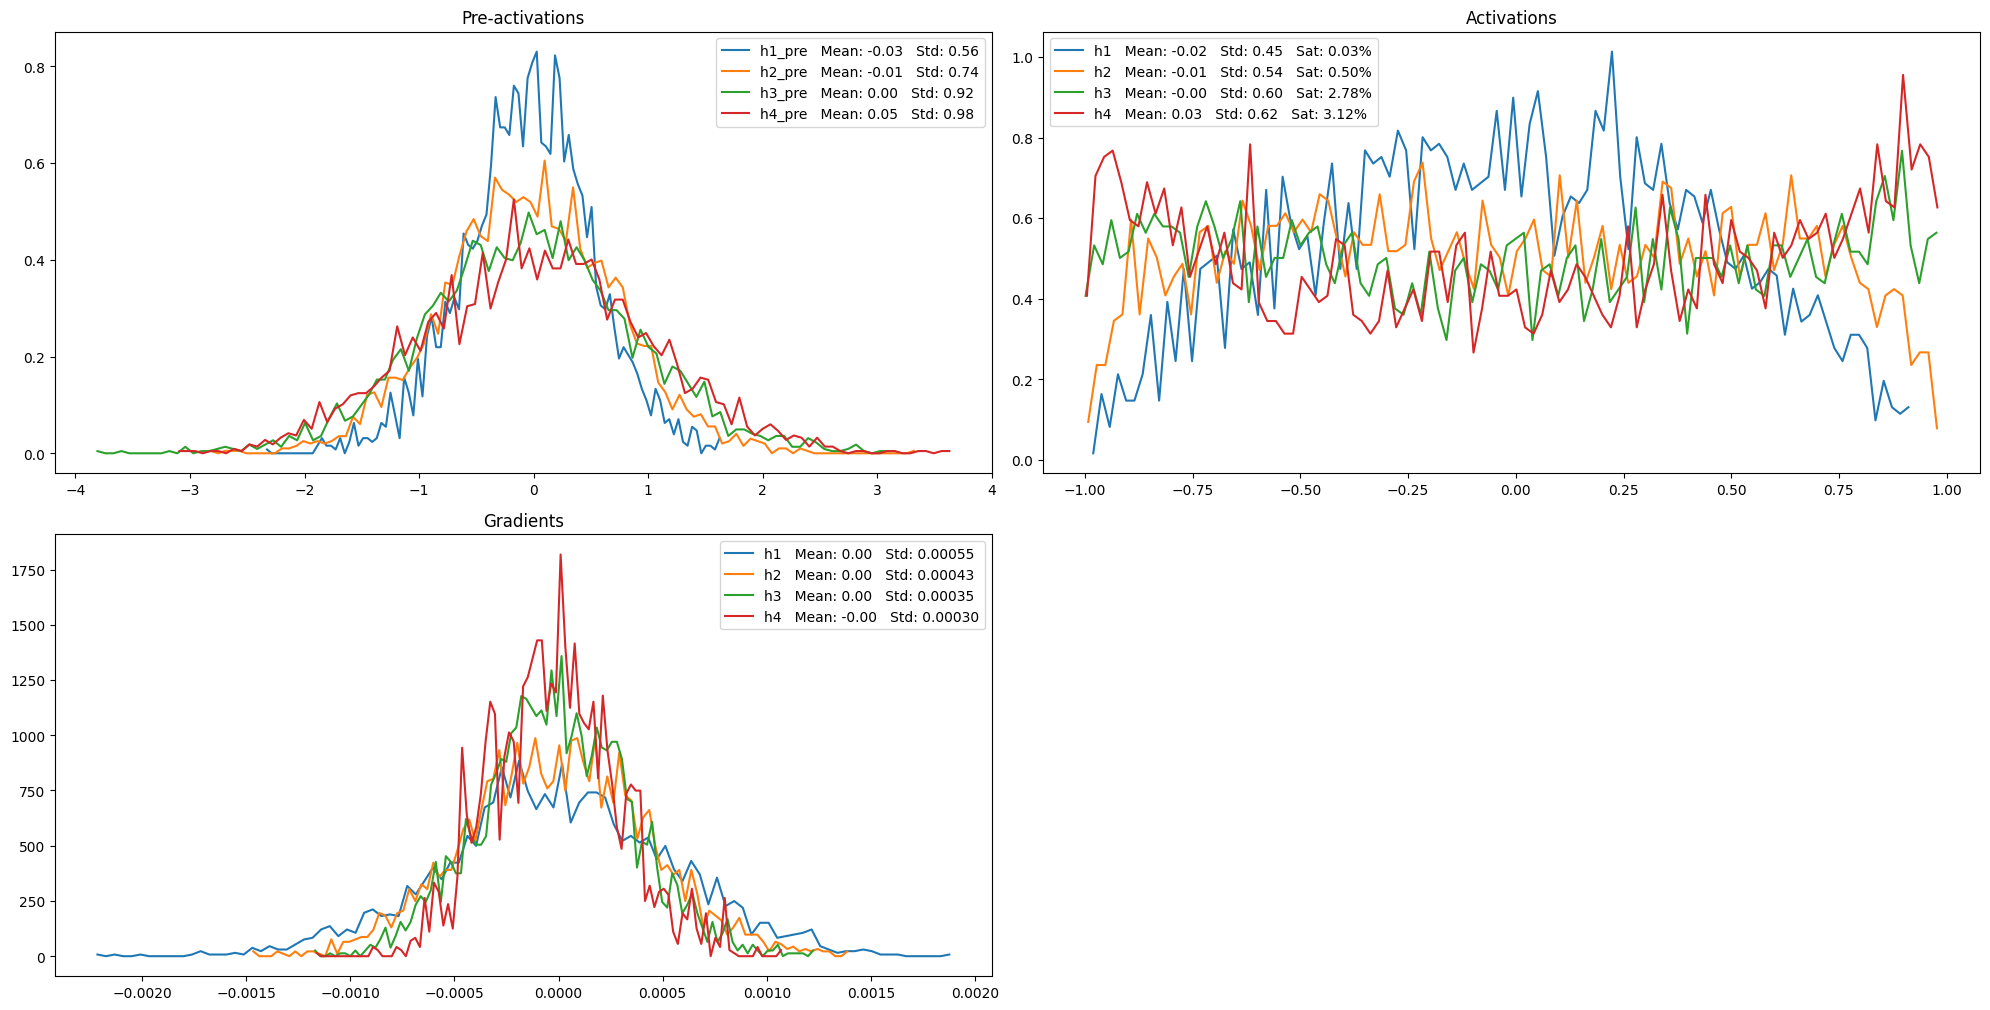

In [534]:
plt.figure(figsize=(20, 15))
legends = []

i = 1

for layer in layers[:-1]:

    if isinstance(layer, Linear):
        h_pre = layer.out

        # pre-activations distribution
        plt.subplot(3, 2, 1)
        hy, hx = torch.histogram(h_pre, density=True)
        plt.plot(hx[:-1].detach(), hy.detach(), label=f'h{i}_pre   Mean: {h_pre.mean():.2f}   Std: {h_pre.std():.2f}')
        plt.title('Pre-activations')
        plt.legend()

    if isinstance(layer, Tanh):
        h = layer.out
        g = layer.out.grad

        # activations distribution
        plt.subplot(3, 2, 2)
        hy, hx = torch.histogram(h, density=True)
        plt.plot(hx[:-1].detach(), hy.detach(), label=f'h{i}   Mean: {h.mean():.2f}   Std: {h.std():.2f}   Sat: {(h.abs() > 0.97).float().mean()*100:.2f}%')
        plt.title('Activations')
        plt.legend()

        # gradients distribution
        plt.subplot(3, 2, 3)
        hy, hx = torch.histogram(g, density=True)
        plt.plot(hx[:-1].detach(), hy.detach(), label=f'h{i}   Mean: {g.mean():.2f}   Std: {g.std():.5f}')
        plt.title('Gradients')
        plt.legend()

        i += 1

plt.tight_layout()

## Batch Normalization

In [17]:


class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        self.gain = torch.ones(dim)
        self.bias = torch.zeros(dim)
        self.r_mean = torch.zeros(dim)
        self.r_var = torch.ones(dim)
    
    def __call__(self, x):

        # calculate forward pass
        if self.training:
            mean = x.mean(0, keepdim=True)
            var = x.var(0, keepdim=True)
        else:
            mean = self.r_mean
            var = self.r_var
        self.out = self.gain * (x - mean) / torch.sqrt(var + self.eps) + self.bias
        
        # update buffers
        if self.training:
            with torch.no_grad():
                self.r_mean = (1 - self.momentum) * self.r_mean + self.momentum * mean
                self.r_var = (1 - self.momentum) * self.r_var + self.momentum * var
        
        return self.out
    
    def parameters(self):
        return [self.gain, self.bias]

In [13]:
def initialize_nn(n_hidden = 100):
    
    layers = [
        Linear(     784, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
        Linear(n_hidden,       10, bias=False),
    ]
    
    with torch.no_grad():
        # make less confident last layer
        layers[-1].weight *= 0.1

        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                layer.weight *= 5/3         # apply kaiming gain
    
    parameters = [p for layer in layers for p in layer.parameters()]
    
    for p in parameters:
        p.requires_grad = True
    
    return layers, parameters

In [20]:
steps = 100       # train iterations
lr = 0.1           # learning rate
batch_size = 32

g = torch.Generator().manual_seed(1)

# intialize neural network
layers, parameters = initialize_nn()

for step in range(steps):
    
    # batch construction
    ix = torch.randint(0, train_x.shape[0], (batch_size,), generator=g)
    Xb = train_x[ix].view(-1, 784)
    Yb = train_y[ix]

    # forward pass
    x = Xb
    for layer in layers:
        x = layer(x)
    
    # calculate loss
    for layer in layers:
        layer.out.retain_grad()       # DEBUG: retain_grad serves for the graphs
    loss = F.cross_entropy(x, Yb)
    if step % 10 == 0 or step == steps - 1:
        print(f"Step: {step:2d}/{steps}     Loss: {loss.item():.4f}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update parameters
    for p in parameters:
        p.data += -lr * p.grad
    
    break

Step:  0/100     Loss: 2.2945


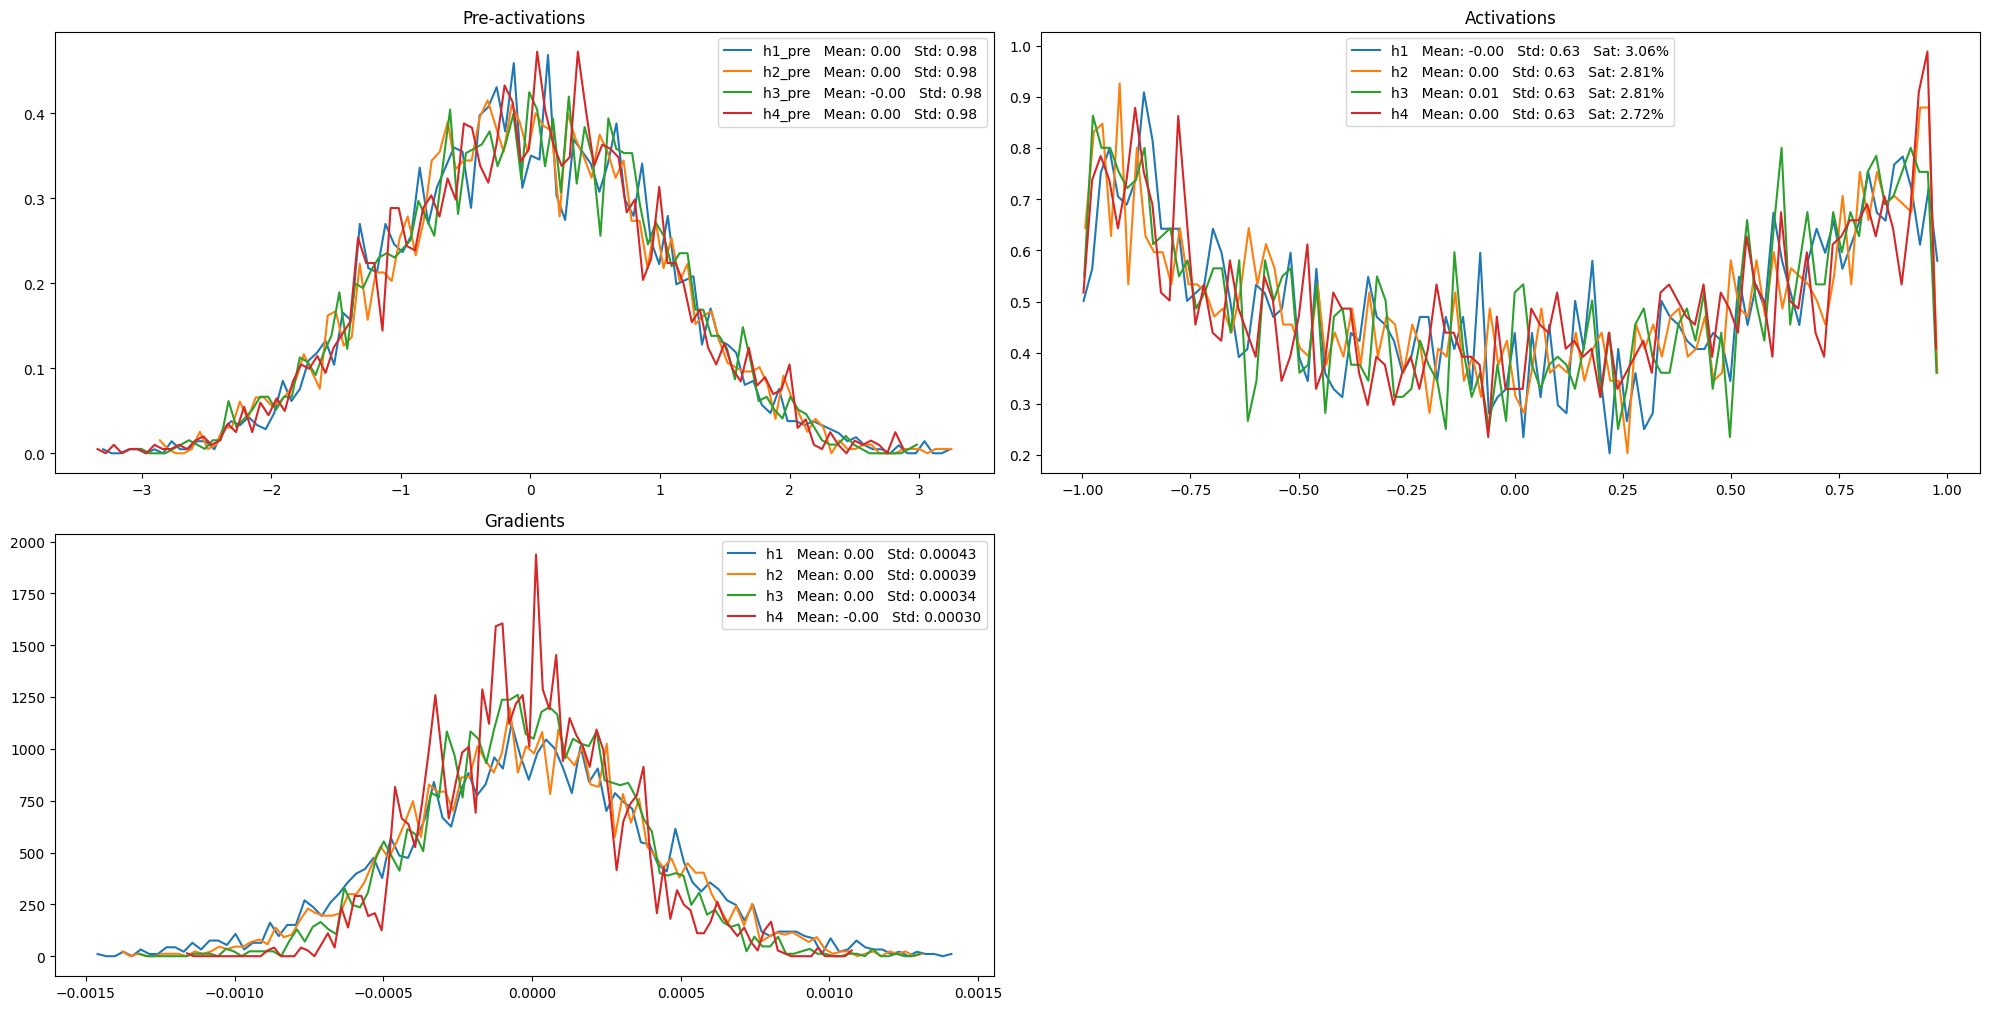

In [21]:
plt.figure(figsize=(20, 15))

i = 1

for layer in layers[:-1]:

    if isinstance(layer, BatchNorm1d):
        h_pre = layer.out

        # pre-activations distribution
        plt.subplot(3, 2, 1)
        hy, hx = torch.histogram(h_pre, density=True)
        plt.plot(hx[:-1].detach(), hy.detach(), label=f'h{i}_pre   Mean: {h_pre.mean():.2f}   Std: {h_pre.std():.2f}')
        plt.title('Pre-activations')
        plt.legend()

    if isinstance(layer, Tanh):
        h = layer.out
        g = layer.out.grad

        # activations distribution
        plt.subplot(3, 2, 2)
        hy, hx = torch.histogram(h, density=True)
        plt.plot(hx[:-1].detach(), hy.detach(), label=f'h{i}   Mean: {h.mean():.2f}   Std: {h.std():.2f}   Sat: {(h.abs() > 0.97).float().mean()*100:.2f}%')
        plt.title('Activations')
        plt.legend()

        # gradients distribution
        plt.subplot(3, 2, 3)
        hy, hx = torch.histogram(g, density=True)
        plt.plot(hx[:-1].detach(), hy.detach(), label=f'h{i}   Mean: {g.mean():.2f}   Std: {g.std():.5f}')
        plt.title('Gradients')
        plt.legend()

        i += 1

plt.tight_layout()